In [1]:
import math 

def discretize(waiting_times):
    for waiting_time in waiting_times:
        if waiting_time > 99.9:
            waiting_time = 99
    return 10000000* abs(round(waiting_times[0])) + 10000*abs(round(waiting_times[1])) + 10*abs(round(waiting_times[2]))

In [2]:
import gym
from gym import spaces
import numpy as np
from math import ceil

class TrafficGenerator(gym.Env):
    
    #doesnt really workj
    def getObs(self):
        # Loop over the packet types
        for i in range(len(self.mean_delay)):

            # Get the current queue for the packet type
            current_queue = self.queues[i]

            # Calculate the length and average waiting time of the current queue
            current_length = len(current_queue)
            current_waiting_time = np.average(current_queue) if current_length > 0 else 0.0
            #print(np.average(current_queue), current_length, current_waiting_time )
            
            
           
            observation.append([current_length, current_waiting_time])

       
        observation = np.array(observation)
        return observation
    
    def __init__(self):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        # Queue maximum length set to 100
        self.observation_space = spaces.Discrete(1000000000)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        
        self.dataType = [0, 1, 2]
        self.arrival_rate = [0.3, 0.25, 0.4]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = self.timeslot
        
        # Initialize the queues
        self.queues = [[], [], []]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        #print(self.totaltime)
        #print("~~~~~~~~~~~~~~~")
        #print("Action Chosen: ", action)
       

        #OBSERVING ENVRONEMNT
        observation = []
        reward =1
        for i in range(len(self.mean_delay_req)):

            # Get the current queue for the packet type
            current_queue = self.queues[i]

            # Calculate the length and average waiting time of the current queue
            current_length = len(current_queue)
            current_waiting_time = np.average(current_queue) if current_length > 0 else 0.0
            #print(np.average(current_queue), current_length, current_waiting_time )
            current_waiting_time = np.round(current_waiting_time, 1)   
            observation.append([current_length, current_waiting_time])
            if i == 2:
                #reward option
                if self.curr_mean_delay_best_effort == 0:
                    curr_mean_delay_best_effort = current_waiting_time
                if self.curr_mean_delay_best_effort < current_waiting_time:
                    self.curr_mean_delay_best_effort = current_waiting_time
                    reward = 1
                elif self.curr_mean_delay_best_effort > current_waiting_time:
                    self.curr_mean_delay_best_effort = current_waiting_time
                    reward = -1
                else:
                    reward = 1
        
                #print(self.curr_mean_delay_best_effort)
                #print(current_waiting_time)


        observation = np.array(observation)  
        
        #Discoruge it from choosing if its not close to the requirement
        #print(f"observation{observation}")
        if observation[0][1] < -4 and action != 0:
            reward = -10
        elif observation[1][1] < -6 and action != 1:
            reward = -10
        
        if (len(self.queues[action]) == 0):
            reward = -25
            #print("LOL STUPID LENGTH IS:", len(self.queues[action])  )
        
        if not any(self.queues):
            reward = 25
            #print("Empty list!")
        
        #UPDATING ENVIORNMENT
        
        
        # services the queues
        #for i in range(len(self.queues)):
            #print("queue ", i, ": has a length of", len(self.queues[i]))
        #print("ACTION queue ", action, ": has a length of", len(self.queues[action]))
        if action < 3 and len(self.queues[action]) > 0:
            self.queues[action].pop(0)

        
        
        #packet generator
        for i in range(len(self.packetInfo)):
            for sublist in self.packetInfo:
                if sublist[0] == i and np.random.uniform() < sublist[1]:
                    self.queues[i].append(self.packet)
                    #print("Appending to queue", i)
        
        #adding time
        for i in range(len(self.queues)):
            for j in range(len(self.queues[i])):
                self.queues[i][j] -= self.timeslot
        
        #Updating the new observaiton 
        waiting_times = []
        for i in range(len(self.mean_delay_req)):

            # Get the current queue for the packet type
            current_queue = self.queues[i]

            # Calculate the length and average waiting time of the current queue
            current_length = len(current_queue)
            current_waiting_time = np.average(current_queue) if current_length > 0 else 0.0
            #print(np.average(current_queue), current_length, current_waiting_time )
            current_waiting_time = np.round(current_waiting_time, 1)
            
            waiting_times.append(current_waiting_time)      
        
    

              
       
        info = {"Mean Delay Req 0": self.mean_delay_req[0],
        "Mean Delay Req 1": self.mean_delay_req[1],
        "Mean Delay Req 2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
        #done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        done = (self.totaltime >= 300)
        
        #print(f"WAITING TIMES {np.array(waiting_times)}")
        waiting_times = discretize(waiting_times)
        
        
        
        return waiting_times, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.queues = [[], [], []]
        self.totaltime = 0
        return [0,0,0]
        
    def render(self):
        pass

In [3]:
env = TrafficGenerator()
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)


State space:  Discrete(1000000000)
Action space:  Discrete(3)


In [4]:
env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    action = env.action_space.sample()
    
    print("chosen", action)
    obs,reward, done, info = env.step(action)
    print(info)
    print("reward", reward)
    
    x = x +1

~~~~~~~~~
chosen 1
{'Mean Delay Req 0': 6, 'Mean Delay Req 1': 4, 'Mean Delay Req 2': inf, 'arrival_rate_0': 0.3, 'arrival_rate_1': 0.25, 'arrival_rate_2': 0.4}
reward 25
~~~~~~~~~
chosen 2
{'Mean Delay Req 0': 6, 'Mean Delay Req 1': 4, 'Mean Delay Req 2': inf, 'arrival_rate_0': 0.3, 'arrival_rate_1': 0.25, 'arrival_rate_2': 0.4}
reward -25
~~~~~~~~~
chosen 2
{'Mean Delay Req 0': 6, 'Mean Delay Req 1': 4, 'Mean Delay Req 2': inf, 'arrival_rate_0': 0.3, 'arrival_rate_1': 0.25, 'arrival_rate_2': 0.4}
reward -25
~~~~~~~~~
chosen 1
{'Mean Delay Req 0': 6, 'Mean Delay Req 1': 4, 'Mean Delay Req 2': inf, 'arrival_rate_0': 0.3, 'arrival_rate_1': 0.25, 'arrival_rate_2': 0.4}
reward -25
~~~~~~~~~
chosen 1
{'Mean Delay Req 0': 6, 'Mean Delay Req 1': 4, 'Mean Delay Req 2': inf, 'arrival_rate_0': 0.3, 'arrival_rate_1': 0.25, 'arrival_rate_2': 0.4}
reward -25
~~~~~~~~~
chosen 1
{'Mean Delay Req 0': 6, 'Mean Delay Req 1': 4, 'Mean Delay Req 2': inf, 'arrival_rate_0': 0.3, 'arrival_rate_1': 0.25, 'ar

In [5]:
import random 

action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
rewardstest = []

# Hyperparameters
total_episodes = 400
total_test_episodes = 100
max_steps = 400
learning_rate = 0.9
gamma = 0.68
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

# Train
for episode in range(total_episodes):
    state = env.reset()
    total_rewards = 0
    print("Episode ", episode,"/", total_episodes )
    for step in range(max_steps):
        exp_exp_tradeoff = random.uniform(0, 1)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state, :])
        else:
            action = env.action_space.sample()

        new_state, reward, done, info = env.step(action)
        new_state = (new_state)
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
        total_rewards += reward
        state = new_state
        if done: 
            rewardstest.append(total_rewards)
            break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * (episode+1))




Episode  0 / 400
Episode  1 / 400
Episode  2 / 400
Episode  3 / 400
Episode  4 / 400
Episode  5 / 400
Episode  6 / 400
Episode  7 / 400
Episode  8 / 400
Episode  9 / 400
Episode  10 / 400
Episode  11 / 400
Episode  12 / 400
Episode  13 / 400
Episode  14 / 400
Episode  15 / 400
Episode  16 / 400
Episode  17 / 400
Episode  18 / 400
Episode  19 / 400
Episode  20 / 400
Episode  21 / 400
Episode  22 / 400
Episode  23 / 400
Episode  24 / 400
Episode  25 / 400
Episode  26 / 400
Episode  27 / 400
Episode  28 / 400
Episode  29 / 400
Episode  30 / 400
Episode  31 / 400
Episode  32 / 400
Episode  33 / 400
Episode  34 / 400
Episode  35 / 400
Episode  36 / 400
Episode  37 / 400
Episode  38 / 400
Episode  39 / 400
Episode  40 / 400
Episode  41 / 400
Episode  42 / 400
Episode  43 / 400
Episode  44 / 400
Episode  45 / 400
Episode  46 / 400
Episode  47 / 400
Episode  48 / 400
Episode  49 / 400
Episode  50 / 400
Episode  51 / 400
Episode  52 / 400
Episode  53 / 400
Episode  54 / 400
Episode  55 / 400
Ep

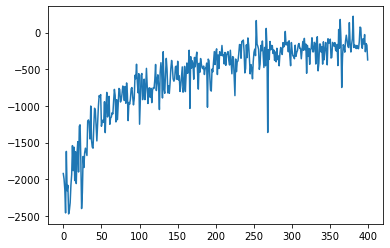

In [6]:
import matplotlib.pyplot as plt
import numpy as np


# Plot the data
plt.plot(rewardstest)

# Show the plot
plt.show()

In [7]:
# Play the Game
rewards = []

for episode in range(total_test_episodes):
    total_rewards = 0
    total_penalties = 0
    state = env.reset()
    #print('='*40)
    #print("[*] Episode", episode)
    #print('='*40)

    for step in range(max_steps):
        env.render()
        action = np.argmax(qtable[state, :])
        state, reward, done, info = env.step(action)
        #print(reward)
        total_rewards += reward
        #WHATS GOING ON HERE
        """
        if reward == -10:
            total_penalties += 1
        else:
            total_rewards += reward
        """
        #print("total time: {}", env.totaltime)
        if done:
            rewards.append(total_rewards)
            #print('[*] Score', total_rewards)
            break

env.close()
print('[*] Average Score: ' + str(sum(rewards) / total_test_episodes))

[*] Average Score: -34.27
